In [1]:
dataset_name = "W14_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
           "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display, display_html 

import Jupyter_module_loader
from utility import *
import gaussian_kde
# display_components, display_pca_data, weighted_kde, setup_directories,\
#                     get_manifest, get_small_files, clean_filename, create_subdir, amalgamate_waves

In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [4]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

var_type (5692, 13)


In [5]:
def sort_by_wave(lst):
    dict_by_wave = {int(x.split("W")[-1]):x for x in lst}
    return [dict_by_wave[x] for x in sorted(dict_by_wave.keys())]
    

In [6]:
max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name,BES_Panel)

In [7]:
# search(BES_Panel,'edlevel')

In [8]:
# mean weights?
# maybe as part of amalgamation?
# BES_Panel[ num_to_weight[8] ]



In [9]:
def get_all_weights(mask):

    wts = BES_Panel[list(num_to_weight.values())][mask]
    # wts.hist(bins=100,figsize=(16,12));

    wts = wts/wts.mean()
    # wts.mean(axis=1).hist(bins=100,figsize=(16,12));
    # # wts = wts/wts.mean(axis=1)
    wts = wts.mean(axis=1)
    wts =wts/wts.mean()
    return wts
# wts

In [10]:
amalgamated_eurefvote = amalgamate_waves(BES_Panel, "euRefVoteW(7|8)$", forward_fill=True)
amalgamated_eurefvote.notnull().sum()

Amalgamating variables: 
{7: 'euRefVoteW7', 8: 'euRefVoteW8'}


39964

In [87]:
df2

0        £10,000 to £14,999 per year
1        £50,000 to £59,999 per year
2          £5,000 to £9,999 per year
3        £10,000 to £14,999 per year
4        £25,000 to £29,999 per year
5        £30,000 to £34,999 per year
6                         Don't know
7               Prefer not to answer
8        £35,000 to £39,999 per year
9        £20,000 to £24,999 per year
10       £45,000 to £49,999 per year
11             under £5,000 per year
12       £40,000 to £44,999 per year
13       £35,000 to £39,999 per year
14       £50,000 to £59,999 per year
15              Prefer not to answer
16       £50,000 to £59,999 per year
17       £25,000 to £29,999 per year
18              Prefer not to answer
19             under £5,000 per year
20       £60,000 to £69,999 per year
21       £25,000 to £29,999 per year
22             under £5,000 per year
23       £20,000 to £24,999 per year
24       £20,000 to £24,999 per year
25       £10,000 to £14,999 per year
26              Prefer not to answer
2

In [93]:
def nice_bar_plot(ser1, ser2, normalize = 'columns', sort_labels=False, output_folder = BES_output_folder, text_width=8):
    var1 = ser1.name
    var2 = ser2.name
    
    mask = ser1.notnull() & ser2.notnull()
    ct = pd.crosstab( ser1, ser2,
                      values= get_all_weights(mask), aggfunc=sum, normalize=normalize)*100
    if sort_labels:
        sorted_labels = list(ser2.value_counts().index)
    else:
        sorted_labels = list(ser2.cat.categories)
        
    unweighted = pd.crosstab( ser1, ser2 )
    errors = 100* np.sqrt(unweighted)/unweighted 
    
    treatment = var2 +" by " + var1
    output_subfolder = create_subdir(output_folder, treatment)
    
    import textwrap 

    wrapper = textwrap.TextWrapper(width=text_width) 

    stacked = ct.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    fig = plt.figure(figsize=(20, 8))
    ax = fig.subplots()

    stacked[var1] = stacked[var1].apply( lambda x: x +" (N="+str(unweighted.sum(axis=1).loc[x])+")" )

    sns.barplot(x=stacked[var2],
                y=stacked['%'],
                hue=stacked[var1],
                ax=ax, order = sorted_labels);

    title = var2 +" by " + var1
    plt.title(title)
    sorted_labels = [sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))]
    ax.set_xticklabels([ wrapper.fill(text=x) for x in sorted_labels], rotation=0, fontsize=14);

    ax.annotate(dataset_citation, (0,0), (0, -140),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
    fname = output_subfolder + title.replace(" ","_") + ".png"
    fig.savefig( fname, bbox_inches='tight' )    

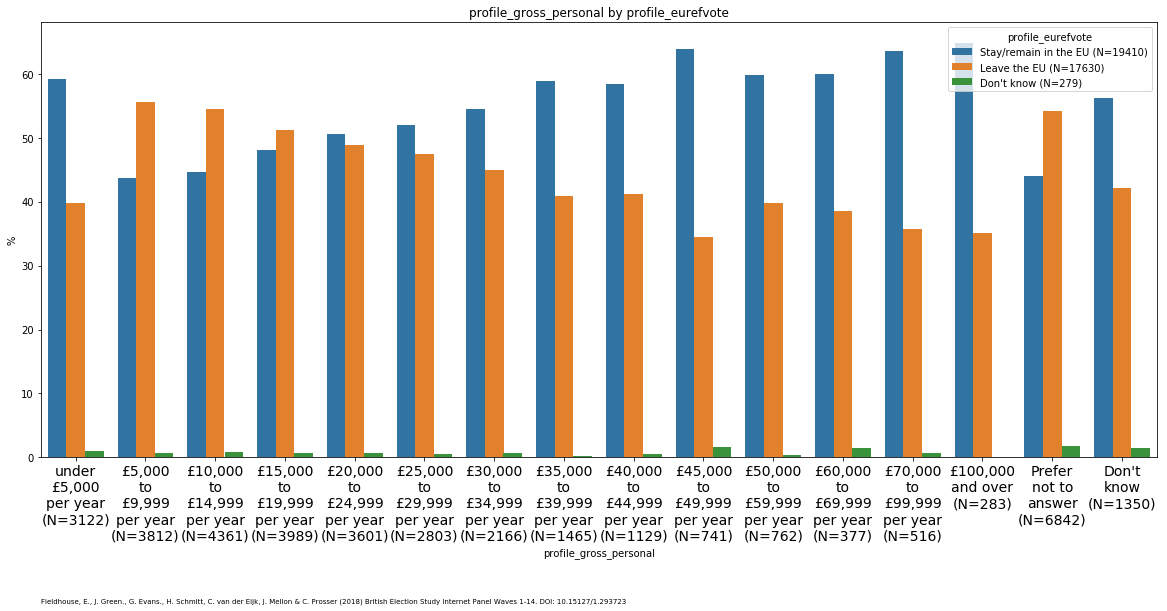

In [94]:
var1 ="profile_eurefvote"
var2 ="profile_gross_personal"

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]
df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer", "Don't know"])


nice_bar_plot(df1, df2)

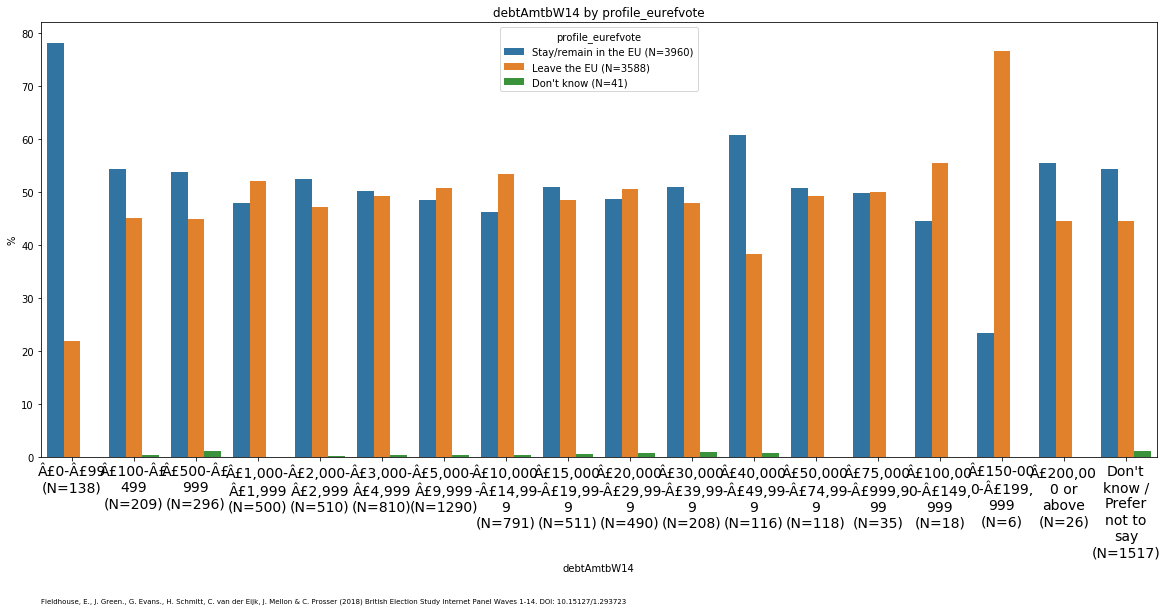

In [103]:
var1 ="profile_eurefvote"
var2 ="debtAmtbW14"

df1 = BES_Panel[var1]
df2 = BES_Panel[var2]
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer", "Don't know"])


nice_bar_plot(df1, df2)

In [95]:
sns.violinplot(df1,df2)

ValueError: Neither the `x` nor `y` variable appears to be numeric.

In [100]:
search(BES_Panel,"amtb",case_sensitive=False)

homeAmtbW14          21912
secondHomeAmtbW14     2501
savingsAmtbW14       19367
debtAmtbW14           8650
dtype: int64

In [97]:
def match(df, pattern, case_sensitive=True, mask=None):
    if mask is None:
           mask = pd.Series(np.ones( (df.shape[0]) )).astype('bool')
    if case_sensitive:
        return df[[x for x in df.columns if re.match(pattern,x)]][mask].notnull().sum()
    else:
        return df[[x for x in df.columns if re.match(pattern, x, re.IGNORECASE)]][mask].notnull().sum()

def search(df, pattern, case_sensitive=False, mask=None):
    if mask is None:
           mask = pd.Series(np.ones( (df.shape[0]) )).astype('bool')
    if case_sensitive:
        return df[[x for x in df.columns if re.search(pattern,x)]][mask].notnull().sum()
    else:
        return df[[x for x in df.columns if re.search(pattern, x, re.IGNORECASE)]][mask].notnull().sum()

In [74]:
# var1 ="profile_eurefvote"
# # var2 ="profile_gross_household"
# var2 ="profile_gross_personal"

# mask = BES_Panel[var1].notnull() & BES_Panel[var2].notnull()
# ct = pd.crosstab( BES_Panel[var1], BES_Panel[var2],
#                   values= get_all_weights(mask), aggfunc=sum, normalize='columns')*100
# # sorted_labels = list(BES_Panel[var2].value_counts().index)
# sorted_labels = list(cat_dictionary[var2]) + ["Prefer not to answer", "Don't know"]

In [75]:
# mask = BES_Panel[var1].notnull() & BES_Panel[var2].notnull()
# unweighted = pd.crosstab( BES_Panel[var1], BES_Panel[var2] )
# errors = 100* np.sqrt(unweighted)/unweighted

In [77]:
# ct.columns = list(cat_dictionary[var2]) + ["Prefer not to answer", "Don't know"]

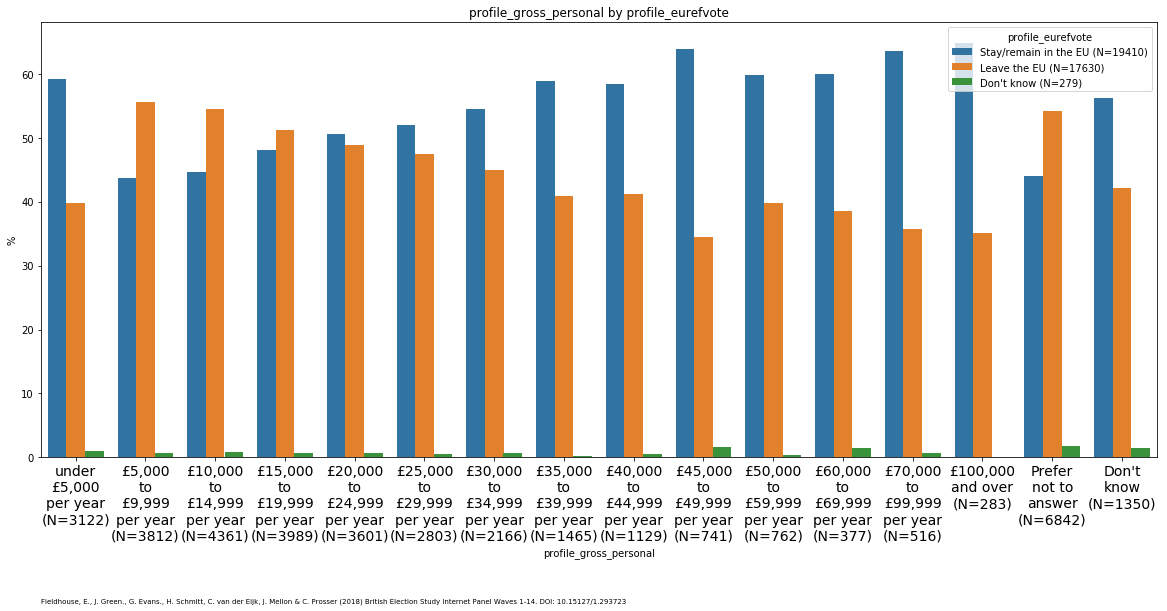

In [79]:
import textwrap 
  
wrapper = textwrap.TextWrapper(width=8) 

stacked = ct.stack().reset_index().rename(columns={0:'%',"level_1":var2})
fig = plt.figure(figsize=(20, 8))
ax = fig.subplots()

stacked[var1] = stacked[var1].apply( lambda x: x +" (N="+str(unweighted.sum(axis=1).loc[x])+")" )

sns.barplot(x=stacked[var2],
            y=stacked['%'],
            hue=stacked[var1],
            ax=ax, order = sorted_labels);

title = var2 +" by " + var1
plt.title(title)
sorted_labels = [sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))]
ax.set_xticklabels([ wrapper.fill(text=x) for x in sorted_labels], rotation=0, fontsize=14);

ax.annotate(dataset_citation, (0,0), (0, -140),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
fname = output_subfolder + title.replace(" ","_") + ".png"
fig.savefig( fname, bbox_inches='tight' )

In [109]:
# amalgamated_eurefvote

In [108]:
wts = get_all_weights(amalgamated_eurefvote.notnull())
((amalgamated_eurefvote=="Leave the EU")*wts).mean(), ((amalgamated_eurefvote=="Stay/remain in the EU")*wts).mean()

(0.44765342122869417, 0.43558521771775943)

In [75]:
wts = get_all_weights(BES_Panel["euRefVoteW8"].notnull())
((BES_Panel["euRefVoteW8"]=="Leave the EU")*wts).mean(), ((BES_Panel["euRefVoteW8"]=="Stay/remain in the EU")*wts).mean()

(0.4626339769186727, 0.42543007882371064)

In [93]:
wts = get_all_weights(BES_Panel["profile_eurefvote"].notnull())
((BES_Panel["profile_eurefvote"]=="Leave the EU")*wts).mean(), ((BES_Panel["profile_eurefvote"]=="Stay/remain in the EU")*wts).mean()


(0.4774822873568766, 0.5119516808933413)

In [69]:
((BES_Panel["profile_eurefvote"]=="Leave the EU")).mean(), ((BES_Panel["profile_eurefvote"]=="Stay/remain in the EU")).mean()

(0.31583517631575375, 0.35340488175515244)

In [60]:
# BES_Panel["profile_eurefvote"].cat.categories

((BES_Panel["profile_eurefvote"]=="Don't know")*wts).mean()

0.006409827988762454

In [61]:
BES_Panel["profile_eurefvote"].notnull().sum()

# how to get the fullest version possible?

49745

In [49]:
((BES_Panel["profile_eurefvote"]=="Leave the EU")*wts).mean()

0.28996800077594587

In [51]:
((BES_Panel["profile_eurefvote"]=="Stay/remain in the EU")*wts).mean()


0.3110076224066323

In [52]:
((BES_Panel["profile_eurefvote"]=="Leave the EU")).mean()

0.31583517631575375

In [53]:
((BES_Panel["profile_eurefvote"]=="Stay/remain in the EU")).mean()

0.35340488175515244

In [ ]:
BES_Panel["profile_eurefvote"]

In [ ]:
# ageGroup, profile_eurefvote
# edlevel

In [113]:
amalgamated_edlevel = amalgamate_waves(BES_Panel, "edlevel")
amalgamated_edlevel.notnull().sum()

Amalgamating variables: 
{1: 'edlevelW1_W6', 7: 'edlevelW7', 8: 'edlevelW8W9W10', 11: 'edlevelW11', 12: 'edlevelW12', 13: 'edlevelW13', 14: 'edlevelW14'}


69141

In [128]:
wts = get_all_weights(BES_Panel["profile_eurefvote"].notnull()&amalgamated_edlevel.notnull())

ct = pd.crosstab( amalgamated_edlevel, BES_Panel["profile_eurefvote"],
             values= wts, aggfunc=sum, normalize='index')*100

sorted_labels = list(amalgamated_edlevel.cat.categories)

In [140]:
# search(BES_Panel,'profile')

In [138]:
BES_Panel[match(BES_Panel,'age(W\d+|Group|$)')].notnull().sum()

ageW1       30386
ageW7       30895
ageW8       33502
ageW9       30036
ageW11      30956
ageW12      34394
ageW13      31136
ageW14      31063
age         18059
ageGroup    18108
dtype: int64

In [ ]:
amalgamated_edlevel = amalgamate_waves(BES_Panel, "edlevel")
amalgamated_edlevel.notnull().sum()

In [143]:
amalgamated_age = amalgamate_waves(BES_Panel, 'age(W\d+)')
amalgamated_age.notnull().sum()

Amalgamating variables: 
{1: 'ageW1', 7: 'ageW7', 8: 'ageW8', 9: 'ageW9', 11: 'ageW11', 12: 'ageW12', 13: 'ageW13', 14: 'ageW14'}


67193

In [145]:
BES_Panel['ageGroup'].cat.categories

Index(['Under 18', '18-25', '26-35', '36-45', '46-55', '56-65', '66+'], dtype='object')

In [155]:
amalgamated_age_group = pd.cut(amalgamated_age,[0,18,26,36,46,56,66,200], right=False, labels=BES_Panel['ageGroup'].cat.categories)
amalgamated_age_group.name = "ageGroup"

In [157]:
Treatment = "euRefVote_by_edlevel"
output_subfolder = create_subdir(BES_output_folder, Treatment)

In [158]:
# amalgamated_age_group

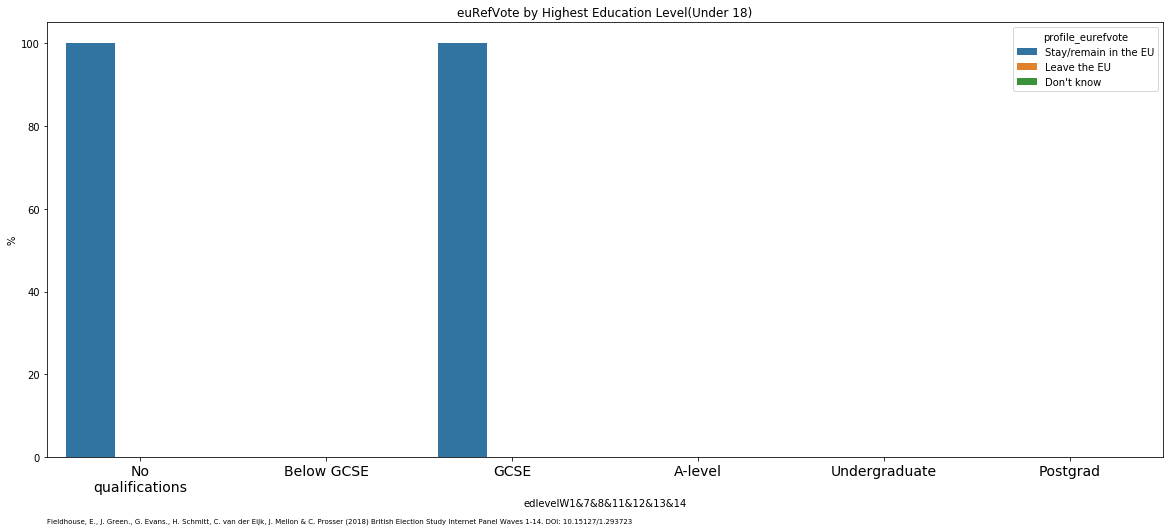

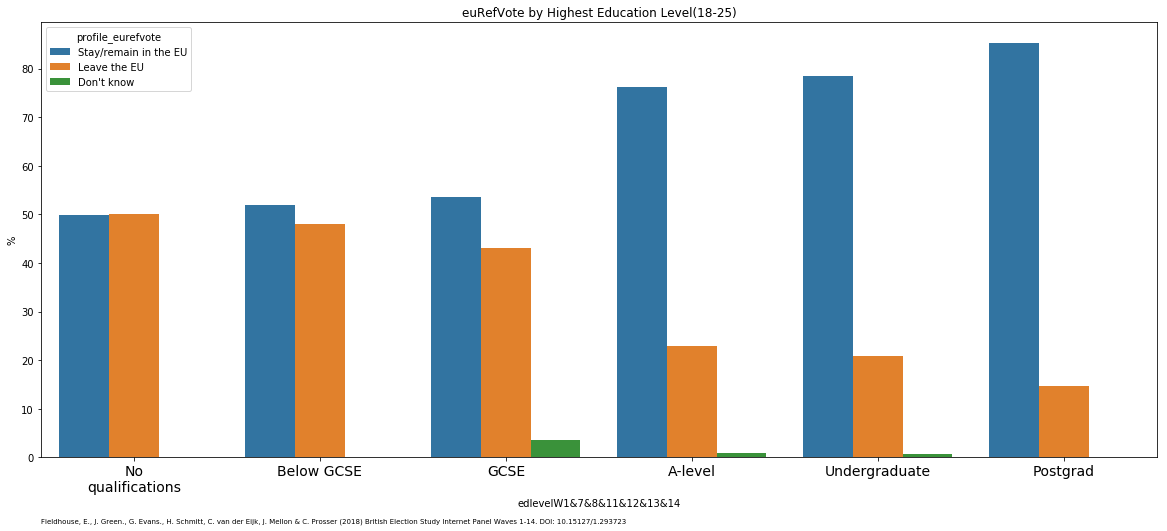

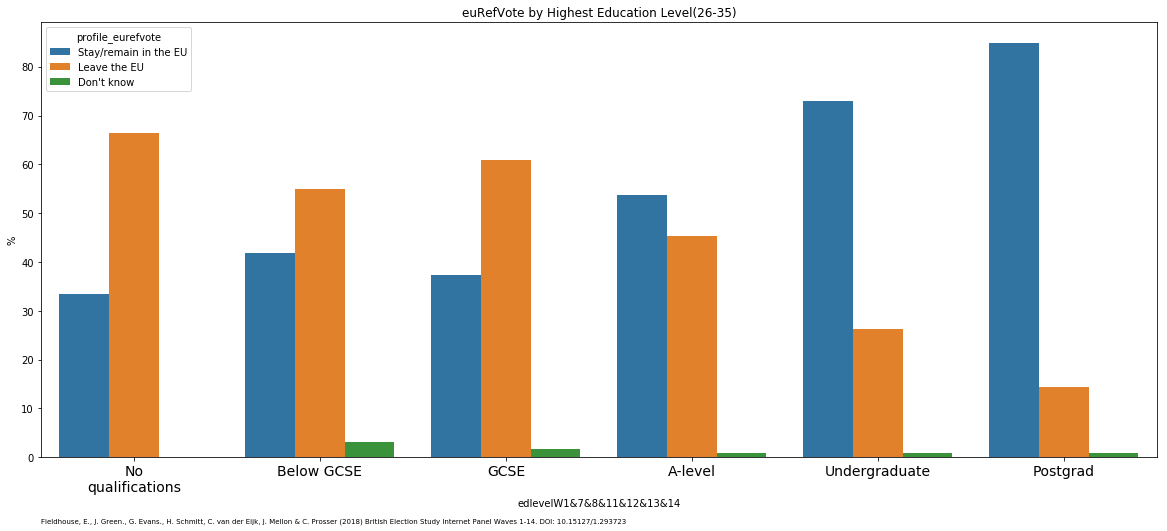

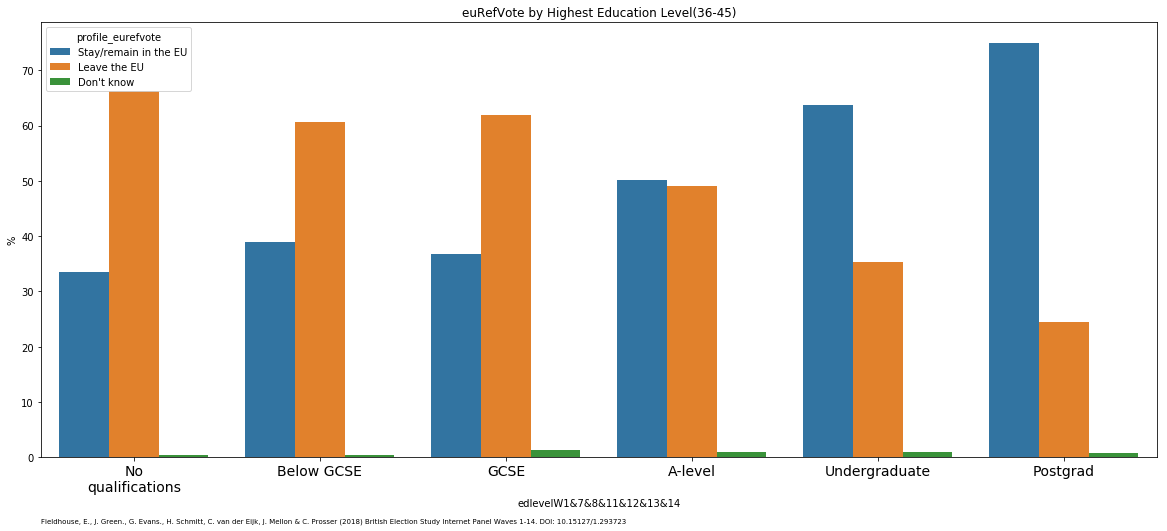

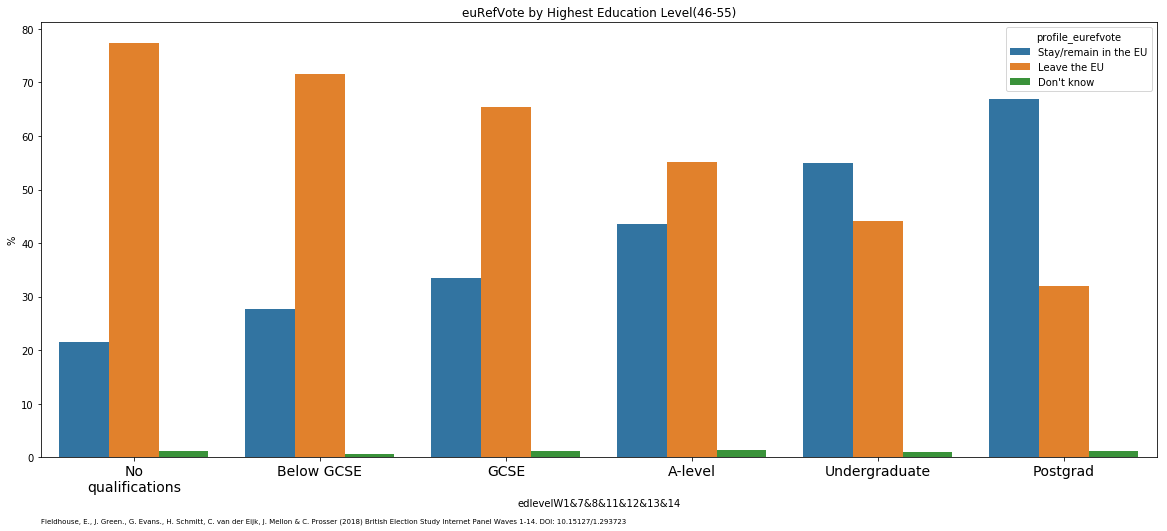

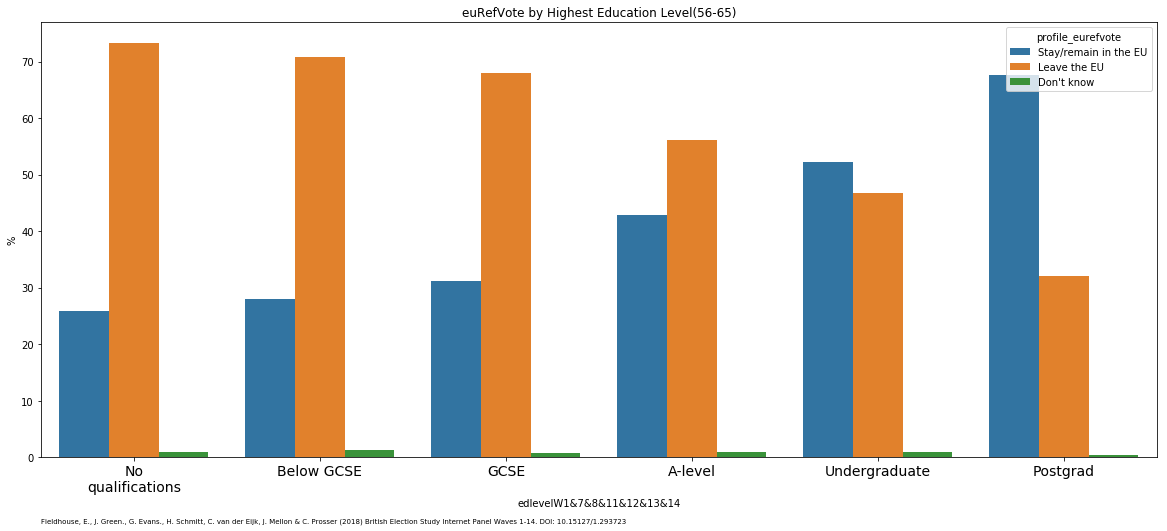

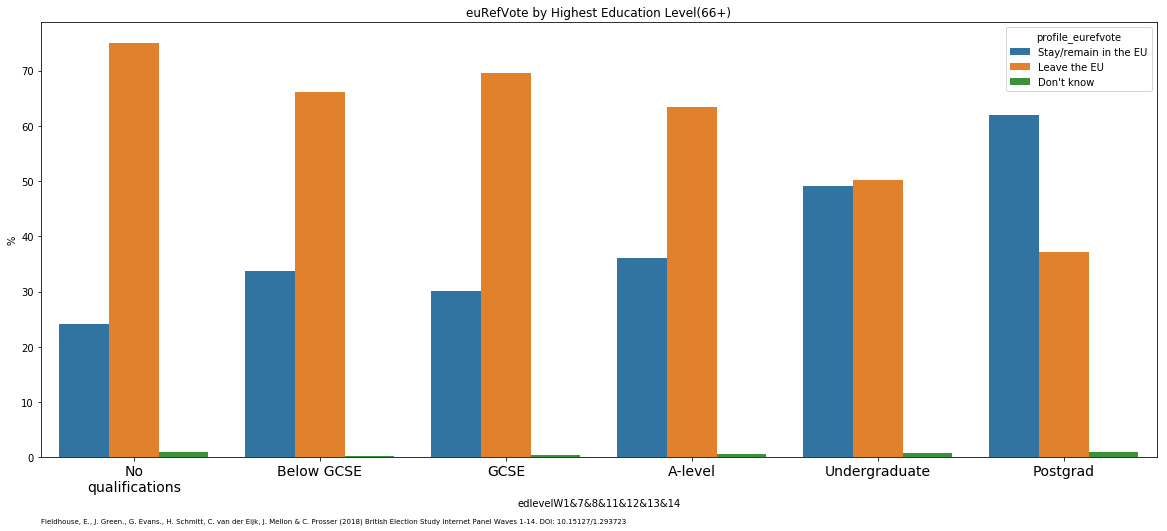

In [159]:
import textwrap 
  
wrapper = textwrap.TextWrapper(width=15)

for age_gp in amalgamated_age_group.cat.categories:
    
    mask = BES_Panel["profile_eurefvote"].notnull() & amalgamated_edlevel.notnull() & (amalgamated_age_group==age_gp)

    wts = get_all_weights( mask )

    ct = pd.crosstab( amalgamated_edlevel[mask], BES_Panel["profile_eurefvote"][mask],
                 values= wts, aggfunc=sum, normalize='index')*100

    sorted_labels = list(amalgamated_edlevel.cat.categories)


    stacked = ct.stack().reset_index().rename(columns={0:'%'})
    fig = plt.figure(figsize=(20, 8))
    ax = fig.subplots()

    sns.barplot(x=stacked[ct.index.name],
                y=stacked['%'],
                hue=stacked[ct.columns.name],
                ax=ax, order = sorted_labels);

    title = "euRefVote by Highest Education Level" + "("+age_gp+")"
    plt.title(title)
    ax.set_xticklabels([ wrapper.fill(text=x) for x in sorted_labels], rotation=0, fontsize=14);

    ax.annotate(dataset_citation, (0,0), (0, -60),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
    fname = output_subfolder + title.replace(" ","_") + ".png"
    fig.savefig( fname, bbox_inches='tight' )

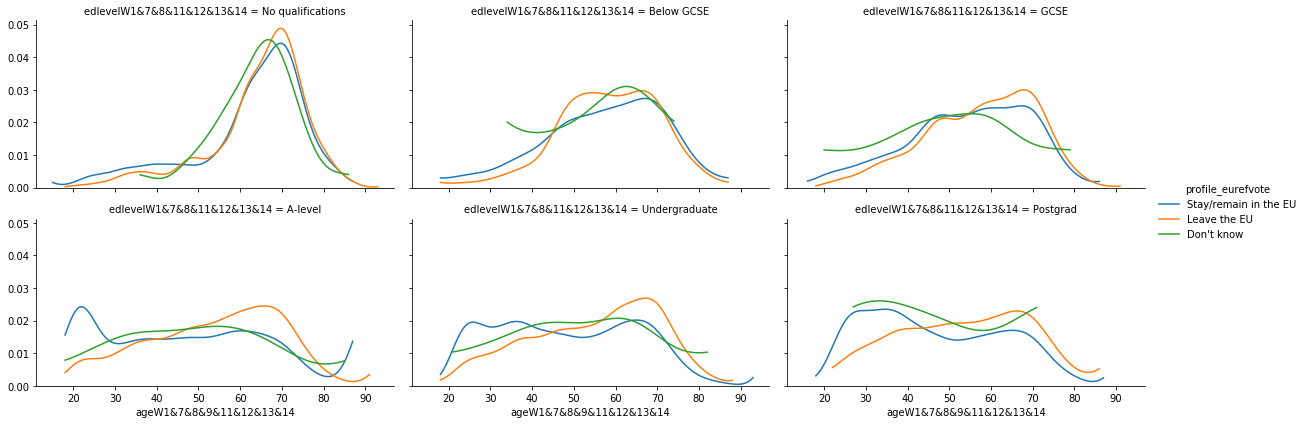

In [177]:
df = pd.concat( [amalgamated_edlevel, amalgamated_age, BES_Panel["profile_eurefvote"]], axis=1  )

grid = sns.FacetGrid(df, hue='profile_eurefvote',
                     col="edlevelW1&7&8&11&12&13&14",
                     col_order=amalgamated_edlevel.cat.categories,
                     col_wrap=3,
                     aspect=1.8)
grid.map(sns.kdeplot,"ageW1&7&8&9&11&12&13&14", cut=0)
grid.add_legend()

plt.show()

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


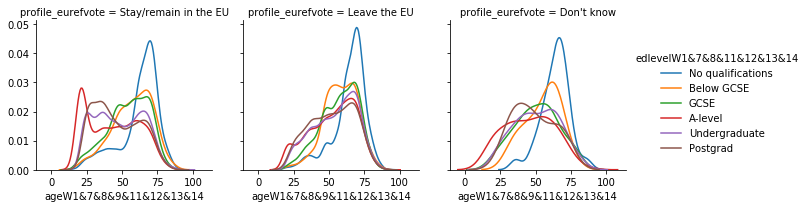

In [168]:
df = pd.concat( [amalgamated_edlevel, amalgamated_age, BES_Panel["profile_eurefvote"]], axis=1  )

grid = sns.FacetGrid(df, col='profile_eurefvote',
                     hue="edlevelW1&7&8&11&12&13&14",
                     col_order=BES_Panel["profile_eurefvote"].cat.categories)
grid.map(sns.kdeplot,"ageW1&7&8&9&11&12&13&14")
grid.add_legend()

plt.show()

In [5]:
## climate change?


In [6]:
[x for x in BES_Panel.columns if "climate" in x]

['climateChangeW7', 'climateChangeW10', 'climateChangeW11']

In [7]:
climateChange = amalgamate_waves(BES_Panel, "climate")

Amalgamating variables: 
{7: 'climateChangeW7', 10: 'climateChangeW10', 11: 'climateChangeW11'}


In [8]:
Notebook_Treatment = "RandomFunPlots_December"
output_subfolder = BES_output_folder + os.sep + "RandomFunPlots_December" + os.sep
notebook_subfolder = create_subdir(BES_output_folder,Notebook_Treatment)

In [9]:
Treatment = "ClimateChange"
output_subfolder = create_subdir(notebook_subfolder,Treatment)

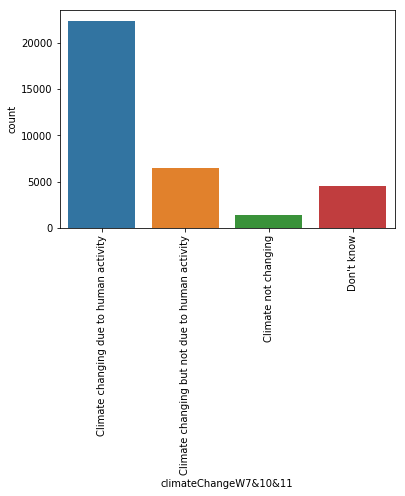

In [10]:
sns.countplot(climateChange);
plt.xticks(rotation=90);
fname = output_subfolder + "climate_change_raw_numbers" + ".png"
plt.savefig( fname, bbox_inches='tight' )

In [11]:
[x for x in BES_Panel.columns if "enviro" in x]

['enviroProtectionW1',
 'enviroProtectionW2',
 'enviroProtectionW3',
 'enviroProtectionW4',
 'enviroGrowthW4',
 'enviroProtectionW6',
 'enviroProtectionW7',
 'enviroGrowthW7',
 'enviroProtectionW12',
 'enviroProtectionW14']

In [21]:
enviroGrowth = amalgamate_waves(BES_Panel, "enviroGrowth")

Amalgamating variables: 
{4: 'enviroGrowthW4', 7: 'enviroGrowthW7'}


In [37]:
enviroGrowth.value_counts().sum()

41264

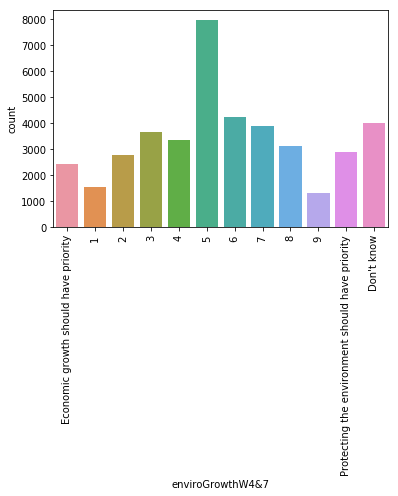

In [26]:
sns.countplot(enviroGrowth);
plt.xticks(rotation=90);
fname = output_subfolder + "enviroGrowth_raw_numbers" + ".png"
plt.savefig( fname, bbox_inches='tight' )

In [23]:
enviroProtection = amalgamate_waves(BES_Panel, "enviroProtection")

Amalgamating variables: 
{1: 'enviroProtectionW1', 2: 'enviroProtectionW2', 3: 'enviroProtectionW3', 4: 'enviroProtectionW4', 6: 'enviroProtectionW6', 7: 'enviroProtectionW7', 12: 'enviroProtectionW12', 14: 'enviroProtectionW14'}


In [39]:
enviroProtection.value_counts()

Not gone far enough           22066
About right                   18841
Not gone nearly far enough    10850
Don't know                     7234
Gone too far                   6560
Gone much too far              2966
Name: enviroProtectionW1&2&3&4&6&7&12&14, dtype: int64

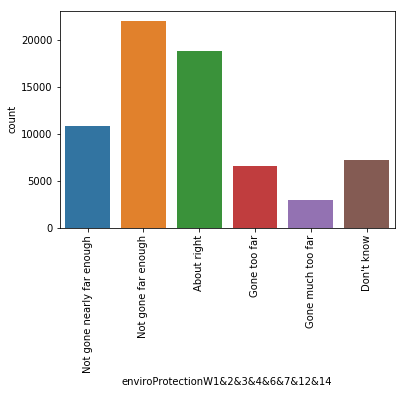

In [27]:
sns.countplot(enviroProtection);
plt.xticks(rotation=90);
fname = output_subfolder + "enviroProtection_raw_numbers" + ".png"
plt.savefig( fname, bbox_inches='tight' )

In [35]:
pd.crosstab(index = climateChange, columns = enviroProtection, normalize='all', margins=True).round(2)

enviroProtectionW1&2&3&4&6&7&12&14,Not gone nearly far enough,Not gone far enough,About right,Gone too far,Gone much too far,Don't know,All
climateChangeW7&10&11,,,,,,,
Climate changing due to human activity,0.14,0.25,0.15,0.04,0.01,0.04,0.64
Climate changing but not due to human activity,0.01,0.03,0.08,0.04,0.02,0.01,0.19
Climate not changing,0.00,0.01,0.02,0.01,0.01,0.00,0.04
Don't know,0.00,0.02,0.04,0.01,0.00,0.04,0.13
All,0.16,0.31,0.29,0.09,0.04,0.10,1.00


In [44]:
enviroProtection_hardcore = (climateChange=="Climate changing due to human activity") & (enviroProtection == "Not gone nearly far enough")
enviroProtection_softcore = (climateChange=="Climate changing due to human activity") & (enviroProtection == "Not gone far enough")

In [279]:
# ep_hardcore_corrs = BES_reduced_with_na[enviroProtection_hardcore|enviroProtection_softcore].corrwith(enviroProtection_hardcore)
# ep_hardcore_corrs.drop([x for x in BES_reduced_with_na.columns if re.match("enviroProtection|climateChange", x)]).dropna().sort_values()

In [278]:
# ep_hardcore_corrs = BES_reduced_with_na.corrwith(enviroProtection_hardcore)
# ep_hardcore_corrs.drop([x for x in BES_reduced_with_na.columns if re.match("enviroProtection|climateChange", x)]).dropna().sort_values()

In [320]:
sample_size_text = "N"
correlation_text = "r"
abs_correlation_text = "abs_r"
p_value_text = "p"
corr_type = "spearman"#"pearson"

top_num = 20
round_places = 2

min_p_value = 0.01
min_variance = 0.0
min_sample_size = 500

pattern = "enviroProtection|climateChange"
name = "enviroProtection_hardcore"

In [321]:
%%time

df1 = BES_reduced_with_na

pattern_list = [x for x in df1.columns if re.match(pattern,x)]
focal_mask = enviroProtection_hardcore.notnull()
variances = df1[focal_mask].var()
low_var_list = list(variances[variances<min_variance].index)
sample_sizes = df1[focal_mask].notnull().sum()
low_sample_size_list = list(sample_sizes[sample_sizes<min_sample_size].index)

drop_list = pattern_list+low_var_list+low_sample_size_list
df1.drop(drop_list,axis=1,inplace=True)

Wall time: 47.2 s


In [322]:
%%time
if corr_type == "pearson":
    df = df1.apply(lambda x: corr_simple_pearsonr(x,enviroProtection_hardcore)).apply(pd.Series)
elif corr_type == "spearman":
    df = df1.apply(lambda x: corr_simple_spearmanr(x,enviroProtection_hardcore)).apply(pd.Series)
    
df.columns = [correlation_text,p_value_text,sample_size_text]
df[sample_size_text] = df[sample_size_text].astype('int')
df[abs_correlation_text] = df[correlation_text].abs()

Wall time: 1min


In [323]:
zero_var_other_way_around_list = list(df[df[correlation_text].isnull()].index)
df.dropna(inplace=True)

insignificant_list = df[df[p_value_text]>min_p_value].index
df.drop(insignificant_list,inplace=True)

df.sort_values(by=abs_correlation_text,ascending=False,inplace=True)
# df=df.round(round_places)

In [324]:
stub_dict = {}
drop_list = []
# drop repeated references to same variable in different waves???
# so, what about different categories??? eg. blahWX_subcat
# how about, just replace wave match as "X"
# create a dictionary keyed on the top corr variable with all the drops inside
for ind in df.index:
    waveless = remove_wave(ind)
    if waveless in stub_dict.keys():
        drop_list.append(ind)
        stub_dict[waveless].append(ind)
    else:
        stub_dict[waveless] = [ind]
df.drop(drop_list,inplace=True)

In [325]:
def display_corr():
    df.index = [x[0:60] for x in df.index]
    df[correlation_text] = df[correlation_text].round(round_places)
    
    df1 = df.sort_values(by=correlation_text, ascending=False)[0:top_num][[correlation_text,p_value_text,sample_size_text]]
    df2 = df.sort_values(by=correlation_text)[0:top_num][[correlation_text,p_value_text,sample_size_text]]
    
    df1[p_value_text]     = df1[p_value_text].apply(lambda x: "{0:0.2f}".format(x))
    df2[p_value_text]     = df2[p_value_text].apply(lambda x: "{0:0.2f}".format(x))
#     df1[[correlation_text,p_value_text]] = df1[[correlation_text,p_value_text]].apply(lambda x: "{0:0.2f}".format(x))
#     df2[[correlation_text,p_value_text]] = df2[[correlation_text,p_value_text]].apply(lambda x: "{0:0.2f}".format(x))

    df1_caption = "Top "+str(top_num)+ " positive "+"("+corr_type+")"+" correlations for "+name
    df2_caption = "Top "+str(top_num)+ " negative "+"("+corr_type+")"+" correlations for "+name

    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption(df1_caption)
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption(df2_caption)

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)


In [326]:
display_corr()

,r,p,N
enviroGrowthW7__Protecting the environment should have prior,0.31,0.00,27820
likeGrnW10__Strongly like,0.3,0.00,26548
likeLucasW10__Strongly like,0.3,0.00,17585
bestPMW10_Jeremy Corbyn,0.3,0.00,18699
ptvGrnW10__Very likely,0.3,0.00,26909
euScepticismW7__Work towards single European government,0.28,0.00,6784
successReduceInequalityGrnW12_Yes,0.28,0.00,6432
competentLucasW13__A great deal of competence,0.26,0.00,10517
euLeaveBigBusinessW10__Much more likely,0.23,0.00,26196
natSecuritySelfW7__Protect civil liberties,0.23,0.00,6593


In [169]:

# var_type.loc["turnoutUKGeneralW1","pruned"]
for ind in df.index:
    print(get_pruned(ind))

ptvGrn
enviroGrowth
likeLucas
euScepticism
likeGrn
ptvGrn
bestPM
ptvGrn
likeLucas
leftRight
likeNuttall
likeGrn
bestPM
approveUKGovt
successReduceInequalityGrn
likeGrn
effectsEUWorkers
ptvGrn
likeLucas
likeGrn
enviroGrowth
likeLucas
bestPM
ptvGrn
approveUKGovt
leftRight
likeGrn
effectsEUWorkers
ptvGrn
competentLucas
likeMay
likeCon
likeMay
competentLucas
natSecuritySpending
likeSEvans
bestPM
handleEUNegotiate
effectsEUEcon
climateChange
leftRight
likeGrn
handleEUNegotiate
likeCon
bestPM
effectsEUEcon
climateChange
ptvGrn
likeMay
conLookAfterBA
handleEUNegotiate
likeCon
euLeaveVoice
likeGrn
euLeaveVoice
keepNukes
leftRight
effectsEUNHS
ptvGrn
keepNukes
handleMIICon
leftRight
al_scale
effectsEUWorkers
likeLucas
al_scale
euPriorityBalance
ptvGrn
generalElectionVoteUnsqueeze
effectsEUNHS
EUIntegrationSelf
ptvGrn
asylumMore
natSecuritySelf
overseasAid
euLeaveVoice
handleMIIGrn
spendLeast
immigSelf
effectsEUNHS
immigrantsWelfareState
likeGrn
ptvCon
effectsEUEcon
ptvCon
euPriorityBalance
like

competentFarron
inequalityChangeLarger
participation
changeNHSLab
efficacyNotUnderstand
responsibleDebtGlobalBanks
labHandleLevelCrime
discrimWomen
negotiationSpecifics_none
tuSupport
satDemEU
resourceAccess
negotiationSpecifics
labHandleNHS
lrLab
ukipFear
profile_newspaper
warmGreece
likeFarron
small_mii_cat
partyContactLab
polAttention
small_mii_cat
efficacyUnderstand
britishness
scotFairShare
lrLD
fbInfo
natSecurityCon
ukCoopTrade
eesEUIntegrationCon
responsibleDebtConservatives
redistCon
efficacyNotUnderstand
populism
coalitionDontDeliver
conPriorities_nhs
bestOnMII
approveScotGovt
mii_cat
EUIntegrationLab
ldUnited
scotElectionVoteConst
partyContactGrn
econGenRetro
partyContact
empathy
mpSecondJob
efficacyNotUnderstand
ukipUnited
resourceAccess
spendMost
lrLD
partyContactOtherParty
grnUnited
small_mii_cat
immigLab
fbInfo
cutsTooFarNHS
achieveReduceImmigCon
discussPolDays
lrLD
euMIISmall
labHandleCostLive
conPartnerUKIP
participation
newspaper
britishness
LRAL_mii_cat
ldTone
busines

noChanceCoalitionPC
spendMost
selfRedistCertain
blameLeave
generalElectionVote
turnoutUKGeneral
partyIdSqueeze
profile_newspaper
econPersonalRetro
labPriorities_costLive
parliamentSupport
ukipPriorities_costLive
ukipPriorities_school
EUIntegrationLD
mii_cat
generalElectionVote
mii_cat
spendMost
euID
partyIdSqueeze
accessJobReference
partyContactOtherParty
immigGreen
ukipPriorities
profile_marital_stat
reasonForVote
partyIdSqueeze
partyId
conPriorities_econ
mii_cat
partyContactCon
dutyToVote
certaintyEUCon
partyIdSqueeze
mapEcon
certaintyEUUKIP
responsibleEducationLD
labUnited
responsibleEducationDontKnow
eesEUIntegrationLD
turnoutUKGeneral
achieveReduceImmigUKIP
discussantVoteName
scotRefExpectation
EUIntegrationUKIP
partyContactOtherParty
mii_cat
ukipPriorities_crime
infoSourceRadio
profile_socgrade
responsibleCostLiveCon
small_mii_cat
generalElectionVoteSqueeze
redistGreen
participation
mii_cat
csplRank
prefTradeoff
profile_sexuality
partyContactLab
blameLeave
participation
scotElect

profile_newspaper
euMIISmall
miilabel
mii_cat
redistLab
LRAL_mii_cat
small_mii_cat
gor
profile_newspaper
polKnowMay
socialDes_dk
ns_sec
gor
profile_past_vote
labAngry
profile_newspaper
profile_newspaper
mii_cat
registered
mii_cat
miilabel
education
EUMIICategory
gor
profile_ethnicity
redistLab
EUMIICategory
likeClegg
mii_cat
profile_religion
singlePartyEffective
miilabel
gor
miilabel
mii_cat
labUnited
fatherCountryBorn
EUMIICategory
euKnow
mii_cat
euroElectionVote
profile_religion
mainSourceIncome
ldUnited
miilabel
euRefTurnoutRetro
belongGroup
labUnited
mii_cat
efficacyPolCare
disability
gor
responsibleEconConservatives
profile_newspaper
schoolKidsInHouse
responsibleImmigDontKnow
gor
mii_cat
mii_cat
small_mii_cat
education
mii_cat
mii_cat
gor
certaintyScotUnion
profile_religion
partyId
gor
bestOnMII
polKnowAssad
noChanceCoalitionLD
labUnited
otherCitizen
mii_cat
generalElectionVote
gor
mii_cat
bestOnMII
achieveReduceImmigLab
ns_sec
education
polKnowMerkel
mii_cat
euKnow
profile_work_t

In [240]:
import six
def render_mpl_table(data, col_width=3.0, row_height=0.325, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(df1, header_columns=0, col_width=2.0);

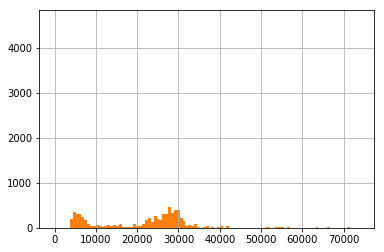

In [123]:
df["p-value"].hist(bins=100)
df["sample size"].hist(bins=100)

In [118]:
df1["blackEquality2W14__Gone much too far"][enviroProtection_hardcore.notnull()].var()
# enviroProtection_hardcore[df1["blackEquality2W14__Gone much too far"].notnull()].var()

1.1621054410934448

In [42]:
pd.crosstab(index = climateChange, columns = enviroGrowth, normalize='index', margins=True).round(2)

enviroGrowthW4&7,Economic growth should have priority,1,2,3,4,5,6,7,8,9,Protecting the environment should have priority,Don't know
climateChangeW7&10&11,,,,,,,,,,,,
Climate changing due to human activity,0.03,0.02,0.05,0.07,0.09,0.20,0.12,0.12,0.10,0.04,0.09,0.07
Climate changing but not due to human activity,0.14,0.08,0.12,0.12,0.09,0.19,0.07,0.06,0.04,0.01,0.02,0.05
Climate not changing,0.20,0.10,0.13,0.11,0.07,0.15,0.04,0.04,0.03,0.02,0.02,0.08
Don't know,0.05,0.04,0.07,0.09,0.06,0.19,0.06,0.05,0.03,0.01,0.02,0.33
All,0.06,0.04,0.07,0.09,0.08,0.20,0.10,0.09,0.08,0.03,0.07,0.10


In [ ]:
## immigSelf distribution by Leave/Remain

In [9]:
[x for x in BES_reduced_with_na.columns if re.match("immigSelf", x)]

['immigSelfW7__Allow many more',
 'immigSelfW8__Allow many more',
 'immigSelfW9__Allow many more',
 'immigSelfW10__Allow many more',
 'immigSelfW11__Allow many more',
 'immigSelfW12__Allow many more',
 'immigSelfW14__Allow many more']

In [54]:
Leavers = BES_Panel["profile_eurefvote"] =="Leave the EU"
Remainers = BES_Panel["profile_eurefvote"] =="Stay/remain in the EU"

In [11]:
amalg_imm = amalgamate_waves(BES_reduced_with_na,"immigSelf",forward_fill=False)
euref_imm = amalgamate_waves(BES_reduced_with_na,"euRefVoteW",forward_fill=False)

In [12]:
amalg_imm.notnull().sum(),euref_imm.notnull().sum()

(56639, 69801)

In [13]:
prof_euref_imm = (BES_Panel["profile_eurefvote"]=="Leave the EU")
prof_euref_imm[BES_Panel["profile_eurefvote"]=="Don't know"] = np.nan

In [14]:
amalg_imm[euref_imm.notnull()].notnull().sum(), amalg_imm[prof_euref_imm.notnull()].notnull().sum()

(55233, 56296)

In [15]:
output_subfolder = BES_output_folder + os.sep + "Immigration_sentiment_by_euref" + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


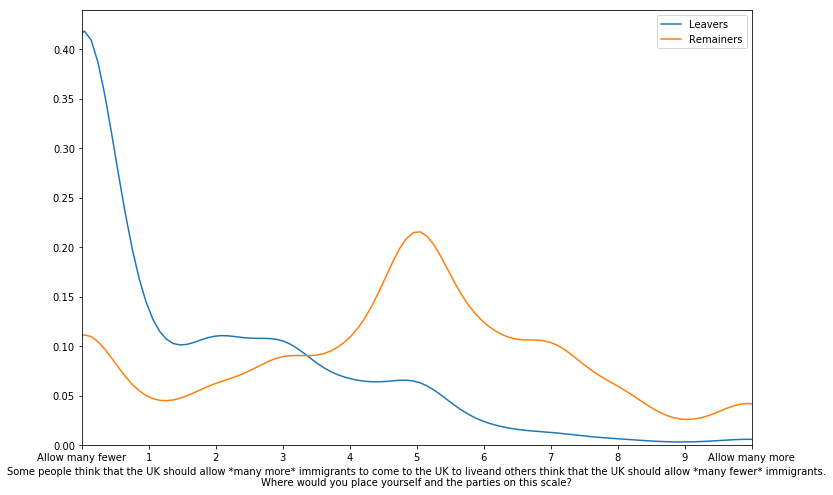

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

Leave_imm =  amalg_imm[prof_euref_imm==1]
Remainer_imm = amalg_imm[prof_euref_imm==0]

sns.kdeplot(Leave_imm,     label="Leavers", bw=.5, ax = axes);#, cut=1);
sns.kdeplot(Remainer_imm,  label="Remainers", bw=.5, ax = axes);#, cut=1);

# ax.set_ylim([0,.2])
axes.set_xlim([0,10]);
axes.set_xticks(list(range(0,11)))
axes.set_xticklabels(BES_Panel["immigSelfW14"].cat.categories[0:11]);
axes.set_xlabel("Some people think that the UK should allow *many more* immigrants to come to the UK to live"+\
                "and others think that the UK should allow *many fewer* immigrants."+\
                "\nWhere would you place yourself and the parties on this scale?");

fname = output_subfolder + "Immigration_sentiment_by_euref" + ".png"
plt.savefig( fname, bbox_inches='tight' )

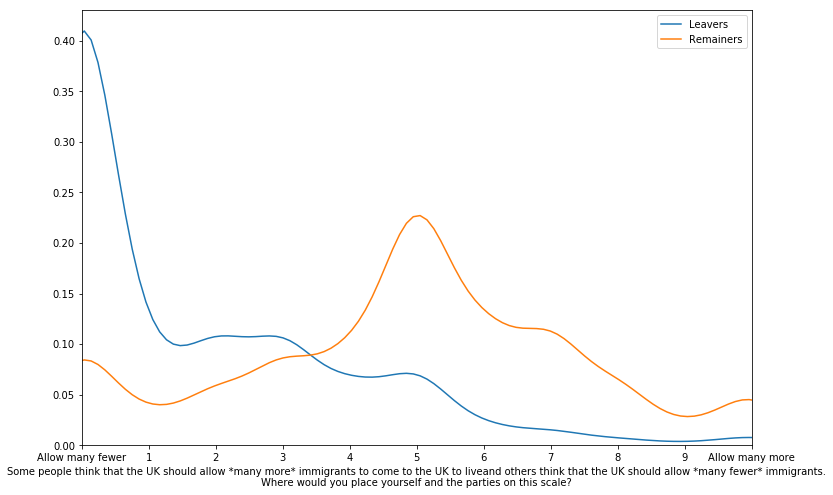

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(12,8))

Leave_imm =  amalg_imm[euref_imm==1]
Remainer_imm = amalg_imm[euref_imm==0]

sns.kdeplot(Leave_imm,     label="Leavers", bw=.5, ax = axes);#, cut=1);
sns.kdeplot(Remainer_imm,  label="Remainers", bw=.5, ax = axes);#, cut=1);

# ax.set_ylim([0,.2])
axes.set_xlim([0,10]);
axes.set_xticks(list(range(0,11)))
axes.set_xticklabels(BES_Panel["immigSelfW14"].cat.categories[0:11]);
axes.set_xlabel("Some people think that the UK should allow *many more* immigrants to come to the UK to live"+\
                "and others think that the UK should allow *many fewer* immigrants."+\
                "\nWhere would you place yourself and the parties on this scale?");

# fname = output_subfolder + "Immigration_sentiment_by_euref" + ".png"
# plt.savefig( fname, bbox_inches='tight' )

In [18]:
Leavers   = (BES_Panel['profile_eurefvote'] == "Leave the EU")
Remainers = (BES_Panel['profile_eurefvote'] == "Stay/remain in the EU")
amalgamated_euMIISmall = amalgamate_waves(BES_Panel, 'euMIISmallW', forward_fill=True)


In [ ]:

SovOrImmLeavers = Leavers&amalgamated_euMIISmall.notnull()

Sov = amalgamated_euMIISmall[SovOrImmLeavers]
BES_sov = BES_reduced[SovOrImmLeavers]
drop_vars = [x for x in BES_reduced.columns if ("euRefVote" in x) or ("profile_eurefvote" in x)\
             or ("euMII" in x) or ("EUMII" in x)]
BES_sov = BES_sov.drop(drop_vars , axis=1)


In [20]:
sovereignty = "Sovereignty/EU bureaucracy"
immigration = "Immigration"
Sov = (amalgamated_euMIISmall==sovereignty)
Imm = (amalgamated_euMIISmall==immigration)
Oth = amalgamated_euMIISmall.notnull() & ~Imm & ~Sov


In [24]:
Sov[Leavers].sum(), Imm[Leavers].sum(), Oth[Leavers].sum()

(3933, 3391, 4088)

In [ ]:
economy = "Economy"
cosmopolitanism = "Cosmopolitanism"
Eco = (amalgamated_euMIISmall==sovereignty)
Cos = (amalgamated_euMIISmall==immigration)

In [25]:
amalgamated_euMIISmall[Remainers].value_counts()

Economy                                   3717
Cosmopolitanism                           1190
Foreign policy                             992
Protection of rights                       899
No content to reason                       882
Campaign/outcome fairness                  778
Other                                      606
Immigration                                495
Other stability or uncertainty concern     449
Sovereignty/EU bureaucracy                 410
Social identity/partisanship               330
Family                                     202
EU spending/regulations/cost               197
EU integration/stability                    64
British/english identity                    34
Name: euMIISmallW8, dtype: int64

In [48]:
# cat_col_mar_dict = {} # category-colour-marker dictionary

# colours = cycle('ycmkgbr')
# markers = cycle('v^<>,oD*x+')

def make_categorical_density_plot():
    fig, axes = plt.subplots(1, 1, figsize=(16,10))    
    sov_vars = (BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match(cat_var+"_", x)]][mask&amalg_imm.notnull()]==1)\
                .sum().sort_values(ascending=False)
    sov_vars = sov_vars.drop(sov_vars[sov_vars<min_sample].index)
    if len(sov_vars.index)==0:
        return
    
    for sov in sov_vars.index:
#         if sov not in cat_col_mar_dict.keys(): # try to give mii consistent colour, marker pairs
#             cat_col_mar_dict[sov] = (next(colours),next(markers))        
        sov_imm = amalg_imm[(BES_reduced_with_na[sov]==1.0)&mask]
        base_label = sov.split("_")[-1]

        (col, mar) = get_cat_col_mar(base_label)
        label = base_label +"(N="+str(sov_vars.loc[sov])+")"
        sns.kdeplot(sov_imm,
                    label=label,
                    bw=.5,
                    ax = axes,
                    color = col,
                    marker = mar,
                    alpha = .75);

    sns.kdeplot(amalg_imm,
                label="Everyone-Leaver/Remainer/Neither"+"(N="+str(amalg_imm.notnull().sum())+")",
                bw=.5,
                ax = axes,
                color = 'k',
                linewidth=7.0,
                alpha = .75);       

    # axes.set_ylim([0,.6])
    axes.set_xlim([0,10]);
    axes.set_xticks(list(range(0,11)))
    axes.set_xticklabels(BES_Panel["immigSelfW14"].cat.categories[0:11]);
    axes.set_xlabel("Some people think that the UK should allow *many more* immigrants to come to the UK to live"+\
                    "and others think that the UK should allow *many fewer* immigrants."+\
                    "\nWhere would you place yourself and the parties on this scale?");
    plt.legend(loc='upper right',title=cat_var);
    wave_descr = BES_file_manifest[ (BES_file_manifest["Only_or_Combined"]=="Only")\
                     & (BES_file_manifest["Wave No"]==wave) ]["Friendlier_Description"].values[0]    
    plt.title(question+"\n"\
             +wave_descr\
             +"\n"+subtitle);

    fname = cat_var + "_" + subtitle + ".png"
    plt.savefig( output_subfolder + clean_filename(fname), bbox_inches='tight' )
#     plt.close()

In [49]:
Treatment = "Sovereignty_vs_Immigration"
base_folder = create_subdir(BES_output_folder, Treatment)

sub_treatment = "category_by_immigself"
output_subfolder = create_subdir(base_folder, sub_treatment)

In [47]:
# get_cat_col_mar('immigration')

In [58]:
amalg_imm = amalgamate_waves(BES_reduced_with_na,"immigSelf",forward_fill=False)
masks = {"Leavers":"Leave the EU","Remainers":"Stay/remain in the EU","Don't know":"Don't know"}
# cat_vars = ["euMIISmallW7","euMIISmallW8","EUMIICategoryW7","EUMIICategoryW8"]
# cat_vars = sorted(list(set(["_".join(x.split("_")[:-1]) for x in BES_reduced_with_na.columns if re.match("bestOnMII|miilabel|small_mii_cat|mii_cat|LRAL_mii_cat|EUMIICategory|euMIISmall",x) ])))
cat_vars = sorted(list(set(["_".join(x.split("_")[:-1]) for x in BES_reduced_with_na.columns if re.match("EUMIICategory",x) ])))
min_sample = 100

for cat_var in cat_vars:
    question = "What matters most to you when deciding how to vote in the EU referendum?"
    wave = int(re.search("W(\d+)",cat_var).groups()[0])
    for subtitle,mask_cat in masks.items():
        print(cat_var,subtitle)
        if ("euRefVoteW"+str(wave)) not in BES_Panel.columns:
            mask = (BES_Panel["profile_eurefvote"]==mask_cat)
        else:
            mask = (BES_Panel["euRefVoteW"+str(wave)]==mask_cat)

        make_categorical_density_plot()


EUMIICategoryW7 Leavers
EUMIICategoryW7 Remainers
EUMIICategoryW7 Don't know
EUMIICategoryW8 Leavers
EUMIICategoryW8 Remainers
EUMIICategoryW8 Don't know


In [211]:
lst = ['LRAL_mii_catW1',
 'LRAL_mii_catW10',
 'LRAL_mii_catW11',
 'LRAL_mii_catW12',
 'LRAL_mii_catW13',
 'LRAL_mii_catW2',
 'LRAL_mii_catW3',
 'LRAL_mii_catW4',
 'LRAL_mii_catW5',
 'LRAL_mii_catW6',
 'LRAL_mii_catW7',
 'LRAL_mii_catW8',
 'LRAL_mii_catW9']
sort_by_wave(lst)

['LRAL_mii_catW1',
 'LRAL_mii_catW2',
 'LRAL_mii_catW3',
 'LRAL_mii_catW4',
 'LRAL_mii_catW5',
 'LRAL_mii_catW6',
 'LRAL_mii_catW7',
 'LRAL_mii_catW8',
 'LRAL_mii_catW9',
 'LRAL_mii_catW10',
 'LRAL_mii_catW11',
 'LRAL_mii_catW12',
 'LRAL_mii_catW13']

In [208]:
sorted(list(set(["_".join(x.split("_")[:-1]) for x in BES_reduced_with_na.columns if re.match("bestOnMII|miilabel|small_mii_cat|mii_cat|LRAL_mii_cat|EUMIICategory|euMIISmall",x) ])))

['EUMIICategoryW7',
 'EUMIICategoryW8',
 'LRAL_mii_catW1',
 'LRAL_mii_catW10',
 'LRAL_mii_catW11',
 'LRAL_mii_catW12',
 'LRAL_mii_catW13',
 'LRAL_mii_catW2',
 'LRAL_mii_catW3',
 'LRAL_mii_catW4',
 'LRAL_mii_catW5',
 'LRAL_mii_catW6',
 'LRAL_mii_catW7',
 'LRAL_mii_catW8',
 'LRAL_mii_catW9',
 'bestOnMIIW1',
 'bestOnMIIW10',
 'bestOnMIIW11',
 'bestOnMIIW12',
 'bestOnMIIW13',
 'bestOnMIIW14',
 'bestOnMIIW2',
 'bestOnMIIW3',
 'bestOnMIIW4',
 'bestOnMIIW5',
 'bestOnMIIW6',
 'bestOnMIIW7',
 'bestOnMIIW8',
 'bestOnMIIW9',
 'euMIISmallW7',
 'euMIISmallW8',
 'mii_catW1',
 'mii_catW10',
 'mii_catW11',
 'mii_catW12',
 'mii_catW13',
 'mii_catW2',
 'mii_catW3',
 'mii_catW4',
 'mii_catW5',
 'mii_catW6',
 'mii_catW7',
 'mii_catW8',
 'mii_catW9',
 'miilabelW1',
 'miilabelW2',
 'miilabelW3',
 'miilabelW4',
 'miilabelW5',
 'miilabelW6',
 'small_mii_catW1',
 'small_mii_catW10',
 'small_mii_catW11',
 'small_mii_catW12',
 'small_mii_catW13',
 'small_mii_catW2',
 'small_mii_catW3',
 'small_mii_catW4',
 'smal

In [185]:
list(set([x.split("W")[0] for x in BES_reduced_with_na.columns if "mii" in x.lower()]))

['handleMIILD',
 'handleMIILab',
 'EUMIICategory',
 'bestOnMII',
 'handleMIIGrn',
 'handleMIICon',
 'miilabel',
 'small_mii_cat',
 'LRAL_mii_cat',
 'euMIISmall',
 'mii_cat',
 'handleMIIUKIP']

In [36]:
sov_cols = [x for x in BES_reduced_with_na.columns if "sov" in x.lower()]
BES_reduced_with_na[sov_cols].notnull().sum()

UKsovereigntyW7__Strongly agree            28353
UKsovereigntyW8__Strongly agree            31153
UKsovereigntyPostW10__Strongly agree       26292
UKsovereigntyPostW11__Strongly agree       27411
UKsovereigntyPostW13__Strongly agree       27330
UKsovereigntyPostW14__Strongly agree       26960
EUMIICategoryW7_sovereignty                22599
euMIISmallW7_Sovereignty/EU bureaucracy    21657
EUMIICategoryW8_sovereignty                16181
euMIISmallW8_Sovereignty/EU bureaucracy    15413
dtype: int64

In [46]:
sov_corr = BES_reduced_with_na[Leavers].corrwith(BES_reduced_with_na["EUMIICategoryW7_sovereignty"][Leavers])
sov_corr.dropna().sort_values()

euMIISmallW7_Immigration                                        -0.350165
EUMIICategoryW7_immigration                                     -0.334493
scotIndepJoinEUW1__Very likely                                  -0.206965
scotIndepJoinEUW2__Very likely                                  -0.178561
cooperateRUKGBPW2__Very likely                                  -0.175416
EUMIICategoryW7_democratic deficit                              -0.173026
euMIISmallW7_Campaign/outcome fairness                          -0.171961
euScepticismW7__Work towards single European government         -0.166412
cooperateRUKGBPW1__Very likely                                  -0.161390
polKnowHollandeW10_Prime Minister of Israel                     -0.160128
euMIISmallW7_Economy                                            -0.159556
euMIISmallW8_Immigration                                        -0.154674
snpLookAfterMCW12__Very closely                                 -0.152811
polKnowKerryW10_Secretary General of t

In [44]:
sov_corr[sov_corr.abs()>=.6].dropna().sort_index()

EUIntegrationSelfW10__Protect our independence                  0.655420
EUIntegrationSelfW11__Protect our independence                  0.660549
EUIntegrationSelfW12__Protect our independence                  0.668960
EUIntegrationSelfW13__Protect our independence                  0.653175
EUIntegrationSelfW14__Protect our independence                  0.637818
EUIntegrationSelfW1__Protect our independence                   0.618248
EUIntegrationSelfW3__Protect our independence                   0.644982
EUIntegrationSelfW4__Protect our independence                   0.632688
EUIntegrationSelfW6__Protect our independence                   0.629332
EUIntegrationSelfW7__Protect our independence                   0.687578
EUIntegrationSelfW8__Protect our independence                   0.671564
EUIntegrationSelfW9__Protect our independence                   0.654135
UKsovereigntyW7__Strongly agree                                 1.000000
UKsovereigntyW8__Strongly agree                    

In [56]:
sov_corr = BES_reduced_with_na[Remainers].corrwith(BES_reduced_with_na["euMIISmallW7_Protection of rights"][Remainers])
sov_corr.dropna().sort_values()

polKnowAssadW10_President of Syria              -0.485071
effectsEUWorkersW7__Much better                 -0.254117
leftRightW11__Right                             -0.250966
govtHandleEconW1__Very well                     -0.247156
happyScotIndepResultNoW2__Extremely happy       -0.245585
approveUKGovtW7__Strongly approve               -0.245244
leftRightW13__Right                             -0.244588
approveUKGovtW10__Strongly approve              -0.243639
approveUKGovtW11__Strongly approve              -0.243500
leftRightW7__Right                              -0.242571
leftRightW10__Right                             -0.241563
leftRightW14__Right                             -0.240772
likeConW10__Strongly like                       -0.240174
likeMayW11__Strongly like                       -0.240066
leftRightW9__Right                              -0.239517
approveUKGovtW3__Strongly approve               -0.239454
approveUKGovtW2__Strongly approve               -0.239351
leftRightW12__

In [57]:
sov_corr = BES_reduced_with_na[Remainers].corrwith(BES_reduced_with_na["euMIISmallW7_Cosmopolitanism"][Remainers])
sov_corr.dropna().sort_values()

polKnowNetanyahuW10_Prime Minister of Israel                   -0.323077
euMIISmallW7_Economy                                           -0.243396
EUIntegrationSelfW3__Protect our independence                  -0.181924
EUIntegrationSelfW1__Protect our independence                  -0.180304
EUIntegrationSelfW7__Protect our independence                  -0.176617
EUIntegrationSelfW4__Protect our independence                  -0.175497
approveEUW2_Disapprove                                         -0.168590
EUIntegrationSelfW2__Protect our independence                  -0.168480
EUMIICategoryW7_economy general                                -0.163660
EUIntegrationSelfW8__Protect our independence                  -0.162372
EUIntegrationSelfW6__Protect our independence                  -0.154300
EUIntegrationSelfW12__Protect our independence                 -0.151779
britishnessW12__Very strongly British                          -0.150780
EUIntegrationSelfW13__Protect our independence     

In [60]:
[x for x in BES_reduced_with_na.columns if "climate" in x.lower()]

['climateChangeW7__Climate not changing',
 'climateChangeW10__Climate not changing',
 'climateChangeW11__Climate not changing']

In [61]:
amalg_climate = amalgamate_waves(BES_reduced_with_na,"climateChangeW",forward_fill=False)

In [63]:
corr_climate = BES_reduced_with_na.corrwith(amalg_climate, drop=True)

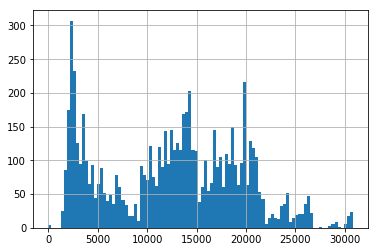

In [64]:
sample_sizes = BES_reduced_with_na[amalg_climate.notnull()].notnull().sum()
sample_sizes.hist(bins=100)

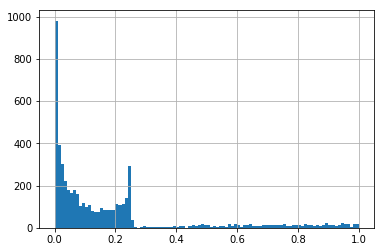

In [72]:
sample_vars = BES_reduced_with_na[amalg_climate.notnull()].var()
sample_vars[sample_vars<=1].hist(bins=100)

In [78]:
low_sample_variance = list(sample_vars[sample_vars<0.01].index)

In [77]:
low_sample_size = list(sample_sizes[sample_sizes<1000].index)

In [67]:
BES_reduced_with_na.shape

(73703, 6864)

In [82]:
corr_climate.drop(low_sample_variance+low_sample_size,errors='ignore').sort_values(ascending=False)

climateChangeW7__Climate not changing                              1.000000
climateChangeW10__Climate not changing                             0.962151
climateChangeW11__Climate not changing                             0.781685
enviroProtectionW3__Gone much too far                              0.454197
enviroProtectionW6__Gone much too far                              0.445071
enviroProtectionW7__Gone much too far                              0.437493
enviroProtectionW2__Gone much too far                              0.434092
enviroProtectionW12__Gone much too far                             0.431481
enviroProtectionW4__Gone much too far                              0.424973
enviroProtectionW1__Gone much too far                              0.411995
enviroProtectionW14__Gone much too far                             0.377303
happyTrumpW10__Extremely happy                                     0.357372
likeNuttallW10__Strongly like                                      0.355601
ptvUKIPW8__V

In [83]:
corr_df_reduced = BES_reduced_with_na.corr(min_periods=100)

In [84]:
import datetime
datetime.datetime.now()

datetime.datetime(2018, 12, 6, 7, 13, 36, 141473)

In [87]:
corr_df.to_msgpack(data_subfolder+"corr_df_reduced.msgpack")

In [86]:
data_subfolder

'../BES_analysis_data/W14_comb\\'

In [88]:
corr_df

,ageW1,turnoutUKGeneralW1__Very likely that I will vote,turnoutUKGeneralW2__Very likely that I will vote,turnoutUKGeneralW3__Very likely that I will vote,turnoutUKGeneralW4__Very likely that I will vote,turnoutUKGeneralW5__Very likely that I will vote,turnoutUKGeneralW7__Very likely that I will vote,turnoutUKGeneralW8__Very likely that I will vote,turnoutUKGeneralW9__Very likely that I will vote,turnoutUKGeneralW10__Very likely that I will vote,...,partyContactLD_4W2_Yes,successReduceInequalityConW12_Yes,bestPMW12_Jeremy Corbyn,partyContactUKIP_3W2_Yes,partyContactUKIP_4W2_Yes,successReduceInequalityUKIPW12_Yes,partyContactUKIP_5W2_Yes,partyContactLDW12_Yes,partyContactLabW12_Yes,partyContactConW12_Yes
ageW1,1.000000,0.197255,0.188298,0.176491,0.165196,0.129728,0.140742,0.130841,0.106640,0.121050,...,0.008540,0.074831,-0.246893,-0.005263,0.003654,0.038569,0.059558,0.007367,-0.050679,0.123966
turnoutUKGeneralW1__Very likely that I will vote,0.197255,1.000000,0.764198,0.759795,0.722853,0.690068,0.658385,0.644661,0.575628,0.637073,...,-0.011803,-0.008027,0.004161,0.015625,-0.030387,-0.002910,0.045551,0.007479,-0.019289,0.035658
turnoutUKGeneralW2__Very likely that I will vote,0.188298,0.764198,1.000000,0.796294,0.749522,0.719718,0.690232,0.668758,0.593488,0.656597,...,0.002412,0.005912,0.011041,-0.003251,-0.019684,-0.006306,0.037717,0.010191,-0.004709,0.032820
turnoutUKGeneralW3__Very likely that I will vote,0.176491,0.759795,0.796294,1.000000,0.777261,0.722657,0.695322,0.678343,0.597681,0.666059,...,0.006367,0.010398,-0.012647,-0.004976,0.000722,0.010162,0.042553,0.010656,-0.005079,0.034747
turnoutUKGeneralW4__Very likely that I will vote,0.165196,0.722853,0.749522,0.777261,1.000000,0.815531,0.713893,0.702592,0.624421,0.676428,...,0.011286,0.037329,-0.000632,0.022456,-0.008737,0.012661,0.024935,0.009404,-0.003206,0.040379
turnoutUKGeneralW5__Very likely that I will vote,0.129728,0.690068,0.719718,0.722657,0.815531,1.000000,0.728354,0.718490,0.642236,0.679955,...,-0.000652,0.040261,0.020196,-0.002992,-0.027304,0.007676,0.025247,0.014554,-0.004100,0.011847
turnoutUKGeneralW7__Very likely that I will vote,0.140742,0.658385,0.690232,0.695322,0.713893,0.728354,1.000000,0.833607,0.726400,0.767871,...,0.006122,0.020414,0.022934,0.014805,-0.010644,0.003176,0.032908,0.025868,-0.014425,0.009854
turnoutUKGeneralW8__Very likely that I will vote,0.130841,0.644661,0.668758,0.678343,0.702592,0.718490,0.833607,1.000000,0.734659,0.759694,...,-0.003978,0.012627,0.017395,0.000140,-0.002534,-0.008324,0.017291,0.021936,-0.013938,0.017731
turnoutUKGeneralW9__Very likely that I will vote,0.106640,0.575628,0.593488,0.597681,0.624421,0.642236,0.726400,0.734659,1.000000,0.719565,...,0.005411,0.023388,0.022219,-0.016361,-0.003391,-0.010991,0.022036,0.010486,-0.001877,0.011632
turnoutUKGeneralW10__Very likely that I will vote,0.121050,0.637073,0.656597,0.666059,0.676428,0.679955,0.767871,0.759694,0.719565,1.000000,...,0.021715,0.032787,0.014077,0.004478,0.005572,-0.002113,0.030815,0.008992,0.000035,0.009162


In [71]:
gc.collect()

35093